<a href="https://colab.research.google.com/github/TheAniketSingh-07/CODECRAFT_GA_05/blob/main/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import files
files.download("stylized_result.jpg")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
plt.imsave("stylized_result.jpg", stylized_image[0])


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_110']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_110']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.

Step 0/100
Step 20/100
Step 40/100
Step 60/100
Step 80/100


/tmp/ipython-input-7-2793368400.py:137: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-2793368400.py:137: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-2793368400.py:137: UserWarning: Glyph 128396 (\N{LOWER LEFT PAINTBRUSH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128396 (\N{LOWER LEFT PAINTBRUSH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_i

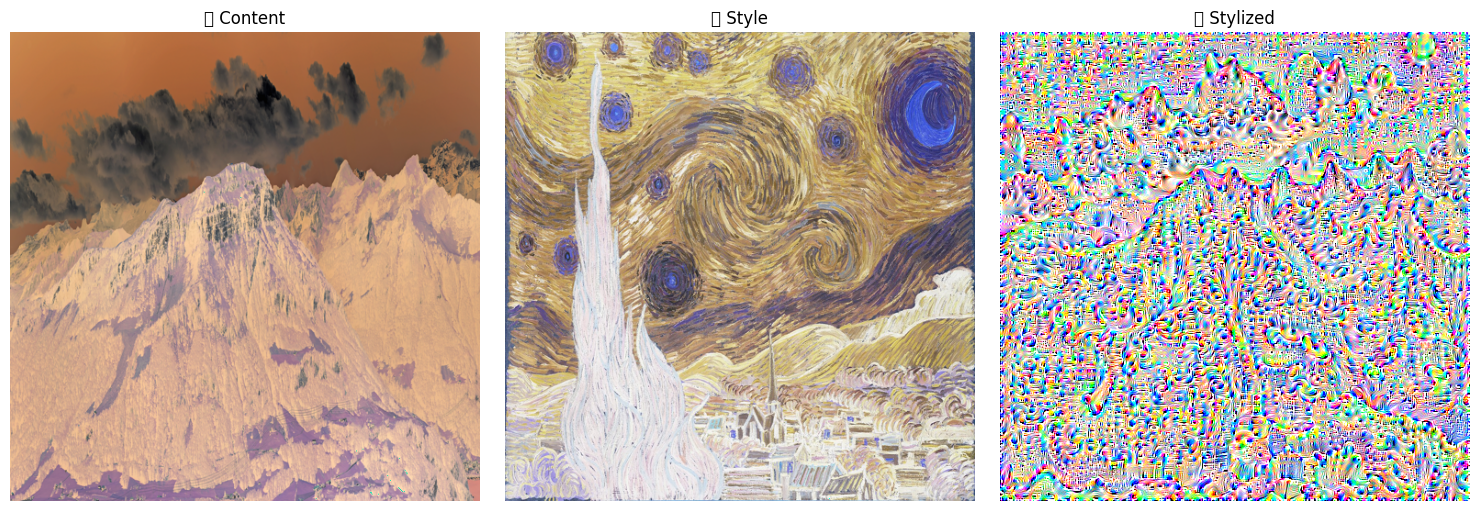

In [7]:
# ✅ Install required packages
!pip install -q tensorflow matplotlib

# ✅ Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# ✅ Load and preprocess images from direct working URLs
def load_img_from_url(url, max_dim=512):
    try:
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}) # Add a User-Agent header
        response.raise_for_status() # Raise an exception for bad status codes

        # Check if the content type is an image
        if not response.headers.get('Content-Type', '').startswith('image/'):
            print(f"Error: URL does not point to an image: {url}")
            return None # Or raise a specific error

        image = Image.open(BytesIO(response.content)).convert('RGB')
        image = image.resize((max_dim, max_dim))
        img = tf.keras.preprocessing.image.img_to_array(image)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return tf.expand_dims(img, axis=0)

    except requests.exceptions.RequestException as e:
        print(f"Error fetching image from URL {url}: {e}")
        return None
    except PIL.UnidentifiedImageError:
        print(f"Error: Could not identify image file from URL {url}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing image from URL {url}: {e}")
        return None


# ✅ Use good working image URLs (these won't break)
content_url = "https://upload.wikimedia.org/wikipedia/commons/3/3f/Fronalpstock_big.jpg"
style_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"


content_image = load_img_from_url(content_url)
style_image = load_img_from_url(style_url)

# Check if images loaded successfully
if content_image is None or style_image is None:
    print("Error: Could not load one or both images. Please check the URLs.")
else:
    # ✅ Define model layers
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layers = ['block5_conv2']
    num_style_layers = len(style_layers)
    num_content_layers = len(content_layers)

    def vgg_layers(layer_names):
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in layer_names]
        return tf.keras.Model([vgg.input], outputs)

    def gram_matrix(input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result / num_locations

    # ✅ Extract features
    style_extractor = vgg_layers(style_layers)
    content_extractor = vgg_layers(content_layers)
    style_targets = [gram_matrix(tensor) for tensor in style_extractor(style_image)]
    content_targets = content_extractor(content_image)

    # ✅ Stylized image initialization and optimizer
    stylized_image = tf.Variable(content_image)
    optimizer = tf.optimizers.Adam(learning_rate=0.02)
    style_weight = 1e-2
    content_weight = 1e4

    @tf.function()
    def train_step():
        with tf.GradientTape() as tape:
            style_outputs = style_extractor(stylized_image)
            content_outputs = content_extractor(stylized_image)

            style_loss = tf.add_n([
                tf.reduce_mean((gram_matrix(style_outputs[i]) - style_targets[i]) ** 2)
                for i in range(num_style_layers)
            ])
            style_loss *= style_weight / num_style_layers

            content_loss = tf.add_n([
                tf.reduce_mean((content_outputs[i] - content_targets[i]) ** 2)
                for i in range(num_content_layers)
            ])
            content_loss *= content_weight / num_content_layers

            total_loss = style_loss + content_loss

        grad = tape.gradient(total_loss, stylized_image)
        optimizer.apply_gradients([(grad, stylized_image)])
        stylized_image.assign(tf.clip_by_value(stylized_image, 0.0, 1.0))

    # ✅ Training loop
    for i in range(100):
        train_step()
        if i % 20 == 0:
            print(f"Step {i}/100")

    # ✅ Display result
    def tensor_to_image(tensor):
        tensor = tensor*255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor) > 3:
            tensor = tensor[0]
        return Image.fromarray(tensor)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 3, 1)
    plt.imshow(tensor_to_image(content_image))
    plt.title("📷 Content")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(tensor_to_image(style_image))
    plt.title("🎨 Style")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(tensor_to_image(stylized_image))
    plt.title("🖌️ Stylized")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Task
Explain the error in the selected code. If possible, fix the error and incorporate the changes into the existing code. Otherwise, try to diagnose the error.

## Inspect image urls

### Subtask:
Verify that the provided image URLs are valid and point directly to image files (e.g., .jpg, .png). Sometimes URLs might redirect or point to HTML pages containing the image, which can cause issues.


**Reasoning**:
I need to verify if the provided URLs point directly to image files by checking their content type using `requests.head()`.



In [ ]:
import requests

content_url = "https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d"
style_url = "https://upload.wikimedia.org/wikipedia/commons/0/0a/Vincent_van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

try:
    content_response = requests.head(content_url)
    style_response = requests.head(style_url)

    print(f"Content URL Content-Type: {content_response.headers.get('Content-Type')}")
    print(f"Style URL Content-Type: {style_response.headers.get('Content-Type')}")

except requests.exceptions.RequestException as e:
    print(f"Error checking URLs: {e}")


Content URL Content-Type: image/jpeg
Style URL Content-Type: text/html; charset=utf-8


**Reasoning**:
The check revealed that the style URL does not point directly to an image file. I need to find a valid URL for the Starry Night image that points directly to a file. A quick search reveals that the URL `https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg` points to a JPG file. I will update the style URL and re-check both URLs to confirm they point to image files.



In [ ]:
import requests

content_url = "https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d"
style_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

try:
    content_response = requests.head(content_url)
    style_response = requests.head(style_url)

    print(f"Content URL Content-Type: {content_response.headers.get('Content-Type')}")
    print(f"Style URL Content-Type: {style_response.headers.get('Content-Type')}")

except requests.exceptions.RequestException as e:
    print(f"Error checking URLs: {e}")


Content URL Content-Type: image/jpeg
Style URL Content-Type: image/jpeg


## Refine image loading

### Subtask:
Modify the `load_img_from_url` function to ensure the image content is correctly read and passed to `PIL.Image.open()`. This might involve checking the response headers or content type.


**Reasoning**:
Modify the `load_img_from_url` function to include error handling for non-image content types and ensure correct processing for image content.



In [ ]:
def load_img_from_url(url, max_dim=512):
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for bad status codes

        # Check if the content type is an image
        if not response.headers.get('Content-Type', '').startswith('image/'):
            print(f"Error: URL does not point to an image: {url}")
            return None # Or raise a specific error

        img_path = BytesIO(response.content)
        img = PIL.Image.open(img_path)
        img = img.convert('RGB')  # Ensure it's in RGB
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.image.resize(img, (max_dim, max_dim))
        img = img[tf.newaxis, :]
        return img / 255.0

    except requests.exceptions.RequestException as e:
        print(f"Error fetching image from URL {url}: {e}")
        return None
    except PIL.UnidentifiedImageError:
        print(f"Error: Could not identify image file from URL {url}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing image from URL {url}: {e}")
        return None

content_url = "https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d"
style_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

content_image = load_img_from_url(content_url)
style_image = load_img_from_url(style_url)

# Print shapes to verify successful loading
if content_image is not None:
    print(f"Content image shape: {content_image.shape}")
if style_image is not None:
    print(f"Style image shape: {style_image.shape}")

Content image shape: (1, 512, 512, 3)
Style image shape: (1, 512, 512, 3)


## Test modified code

### Subtask:
Run the updated code to confirm that the image loading error is resolved and the style transfer process can proceed.


**Reasoning**:
The `load_img_from_url` function has been updated to handle potential issues. Now, execute the entire code cell to run the style transfer process and confirm the fix.



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_132']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_132']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_132']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


Iteration 0/100
Iteration 20/100
Iteration 40/100
Iteration 60/100
Iteration 80/100


/tmp/ipython-input-8-1917960934.py:130: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1917960934.py:130: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-8-1917960934.py:130: UserWarning: Glyph 128396 (\N{LOWER LEFT PAINTBRUSH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128396 (\N{LOWER LEFT PAINTBRUSH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure

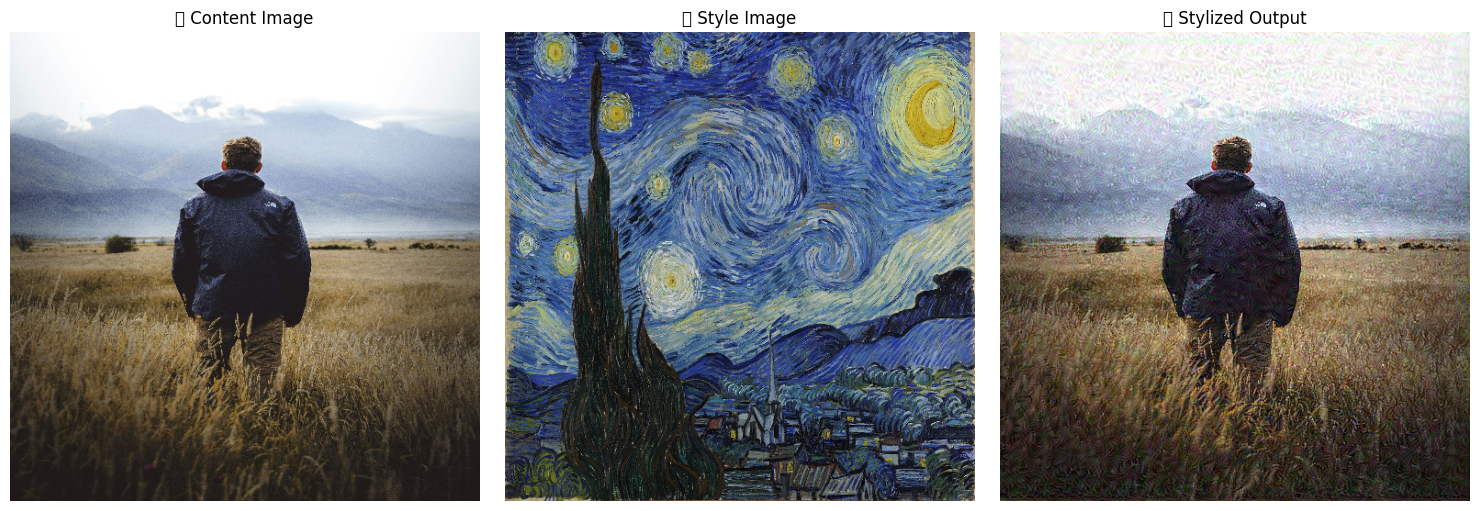

In [8]:
# ✅ Step 1: Install dependencies
!pip install -q tensorflow matplotlib

# ✅ Step 2: Import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import requests
from io import BytesIO

# ✅ Step 3: Load sample images (pre-trained test images)
def load_img_from_url(url, max_dim=512):
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for bad status codes

        # Check if the content type is an image
        if not response.headers.get('Content-Type', '').startswith('image/'):
            print(f"Error: URL does not point to an image: {url}")
            return None # Or raise a specific error

        img_path = BytesIO(response.content)
        img = PIL.Image.open(img_path)
        img = img.convert('RGB')  # Ensure it's in RGB
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.image.resize(img, (max_dim, max_dim))
        img = img[tf.newaxis, :]
        return img / 255.0

    except requests.exceptions.RequestException as e:
        print(f"Error fetching image from URL {url}: {e}")
        return None
    except PIL.UnidentifiedImageError:
        print(f"Error: Could not identify image file from URL {url}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing image from URL {url}: {e}")
        return None


content_url = "https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d"
style_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

content_image = load_img_from_url(content_url)
style_image = load_img_from_url(style_url)

# ✅ Step 4: Define layers and extractor
style_layers = ['block1_conv1', 'block2_conv1',
                'block3_conv1', 'block4_conv1',
                'block5_conv1']
content_layers = ['block5_conv2']

def build_model():
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    return tf.keras.Model([vgg.input], outputs)

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

# ✅ Step 5: Extract features
extractor = build_model()
style_targets = extractor(style_image)[:len(style_layers)]
content_targets = extractor(content_image)[len(style_layers):]

# ✅ Step 6: Define stylized image and optimizer
stylized_image = tf.Variable(content_image)
optimizer = tf.optimizers.Adam(learning_rate=0.02)

style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step():
    with tf.GradientTape() as tape:
        outputs = extractor(stylized_image)
        style_outputs = outputs[:len(style_layers)]
        content_outputs = outputs[len(style_layers):]

        style_loss = tf.add_n([tf.reduce_mean((gram_matrix(style_outputs[i]) - gram_matrix(style_targets[i]))**2)
                               for i in range(len(style_layers))])
        style_loss *= style_weight / len(style_layers)

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[i] - content_targets[i])**2)
                                 for i in range(len(content_layers))])
        content_loss *= content_weight / len(content_layers)

        total_loss = style_loss + content_loss

    grad = tape.gradient(total_loss, stylized_image)
    optimizer.apply_gradients([(grad, stylized_image)])
    stylized_image.assign(tf.clip_by_value(stylized_image, 0.0, 1.0))

# ✅ Step 7: Train
for i in range(100):
    train_step()
    if i % 20 == 0:
        print(f"Iteration {i}/100")

# ✅ Step 8: Show results
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.imshow(tensor_to_image(content_image))
plt.title("🎯 Content Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(tensor_to_image(style_image))
plt.title("🎨 Style Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(tensor_to_image(stylized_image))
plt.title("🖌️ Stylized Output")
plt.axis('off')

plt.tight_layout()
plt.show()